In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


In [25]:
# 導入資料
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
data = pd.read_csv(url, names=columns, sep=',\s', engine='python')


In [26]:
# 資料前處理
print(f"數據筆數: {data.shape[0]}")


## 1. 刪除缺失值 因為資料筆數夠多 採用刪除有缺失值的資料
data.replace('?', np.nan, inplace=True)  # 將 '?' 替換為 NaN
data.dropna(inplace=True)  # 刪除包含缺失值的行
print(f"剩下的數據筆數: {data.shape[0]}")

'''
數據筆數: 32561
剩下的數據筆數: 30162
'''

## 2. 分離特徵和標籤
X = data.drop(['income'], axis=1)
y_classification = data['income'].apply(lambda x: 1 if x == '>50K' else 0)   # 分類任務的目標變量
y_regression = data['hours-per-week']    # 迴歸任務的目標變量


## 3. 定義類別和數值特徵的列
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_features = X.columns.difference(categorical_features)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## 4. 分割數據集 
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X_preprocessed, y_classification, y_regression, test_size=0.2, random_state=42)


數據筆數: 32561
剩下的數據筆數: 30162


In [117]:
# 績效指標封裝

# 計算分類性能指標
def classification_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# 計算迴歸性能指標
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse
    

Epoch 1/100
76/76 [==============================] - 1s 9ms/step - loss: 279.7976 - output_classification_loss: 0.4919 - output_regression_loss: 279.3057 - output_classification_accuracy: 0.7690 - output_regression_mse: 279.3057 - val_loss: 7.5712 - val_output_classification_loss: 0.3571 - val_output_regression_loss: 7.2140 - val_output_classification_accuracy: 0.8361 - val_output_regression_mse: 7.2140
Epoch 2/100
76/76 [==============================] - 0s 6ms/step - loss: 5.2249 - output_classification_loss: 0.3470 - output_regression_loss: 4.8779 - output_classification_accuracy: 0.8372 - output_regression_mse: 4.8779 - val_loss: 2.9454 - val_output_classification_loss: 0.3323 - val_output_regression_loss: 2.6131 - val_output_classification_accuracy: 0.8462 - val_output_regression_mse: 2.6131
Epoch 3/100
76/76 [==============================] - 0s 6ms/step - loss: 2.7465 - output_classification_loss: 0.3312 - output_regression_loss: 2.4152 - output_classification_accuracy: 0.8460 -

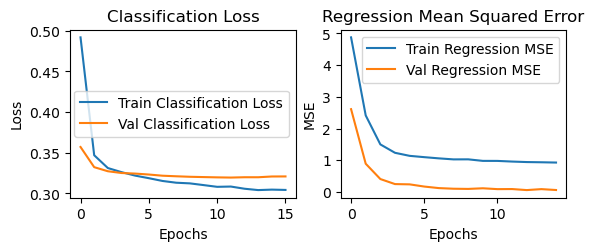

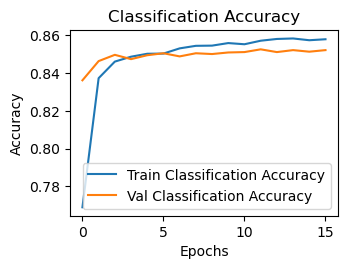

In [123]:
# 定義分類和迴歸任務的損失函數
classification_loss = 'binary_crossentropy'
regression_loss = 'mean_squared_error'

# 定義神經網絡結構
def create_multi_task_model(input_shape_classification, input_shape_regression):
    input_classification = Input(shape=input_shape_classification, name='input_classification')
    input_regression = Input(shape=input_shape_regression, name='input_regression')

    # 分類任務
    x1 = Dense(42, activation='relu')(input_classification)
    x1 = Dropout(0.1)(x1) 
    x1 = Dense(21, activation='relu')(x1)
    x1 = Dropout(0.05)(x1) 
    output_classification = Dense(1, activation='sigmoid', name='output_classification')(x1)

    # 迴歸任務
    x2 = Dense(1024, activation='relu')(input_regression)
    x2 = Dropout(0.1)(x2)
    x2 = Dense(512, activation='relu')(x2)
    x2 = Dropout(0.05)(x2)
    output_regression = Dense(1, name='output_regression')(x2)

    model = Model(inputs=[input_classification, input_regression], outputs=[output_classification, output_regression])
    model.compile(optimizer='adam', loss={'output_classification': classification_loss, 'output_regression': regression_loss},metrics={'output_classification': 'accuracy', 'output_regression': 'mse'})
    return model
    
# 將稀疏矩陣轉換為稠密矩陣
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()


# 創建並訓練多任務模型
multi_task_model = create_multi_task_model((X_train_dense.shape[1],), (X_train_dense.shape[1],))
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# 训练模型并应用早停策略
history = multi_task_model.fit({'input_classification': X_train_dense, 'input_regression': X_train_dense},
                               {'output_classification': y_train_class, 'output_regression': y_train_reg},
                               epochs=100, batch_size=256, validation_split=0.2, callbacks=[early_stopping])

# 進行預測
y_train_pred_class, y_train_pred_reg = multi_task_model.predict({'input_classification': X_train_dense, 'input_regression': X_train_dense})
y_test_pred_class, y_test_pred_reg = multi_task_model.predict({'input_classification': X_test_dense, 'input_regression': X_test_dense})

# 提取第一列，因為迴歸任務的預測結果是一維的
y_train_pred_reg = y_train_pred_reg.flatten()
y_test_pred_reg = y_test_pred_reg.flatten()

# 計算績效指標
precision_train, recall_train, f1_train = classification_metrics(y_train_class, np.round(y_train_pred_class))
precision_test, recall_test, f1_test = classification_metrics(y_test_class, np.round(y_test_pred_class))
mae_train, mape_train, rmse_train = regression_metrics(y_train_reg, y_train_pred_reg)
mae_test, mape_test, rmse_test = regression_metrics(y_test_reg, y_test_pred_reg)

# 輸出績效指標
print("訓練資料的績效:")
print(f"分類任務 - Precision: {precision_train}, Recall: {recall_train}, F1: {f1_train}")
print(f"迴歸任務 - MAE: {mae_train}, MAPE: {mape_train}, RMSE: {rmse_train}")
print("\n測試資料的績效:")
print(f"分類任務 - Precision: {precision_test}, Recall: {recall_test}, F1: {f1_test}")
print(f"迴歸任務 - MAE: {mae_test}, MAPE: {mape_test}, RMSE: {rmse_test}")

# 绘制训练集和验证集的分类loss

plt.subplot(2, 2, 1)
plt.plot(history.history['output_classification_loss'], label='Train Classification Loss')
plt.plot(history.history['val_output_classification_loss'], label='Val Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练集和验证集的回归loss

plt.subplot(2, 2, 2)
plt.plot(history.history['output_regression_loss'][1:], label='Train Regression MSE')
plt.plot(history.history['val_output_regression_loss'][1:], label='Val Regression MSE')
plt.title('Regression Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# 绘制训练集和验证集的分类精确度
plt.subplot(2, 2, 3)
plt.plot(history.history['output_classification_accuracy'], label='Train Classification Accuracy')
plt.plot(history.history['val_output_classification_accuracy'], label='Val Classification Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



plt.tight_layout()
plt.show()